<div id="instructions" style="border-radius: 5px; background-color:#f5f5f5;" >
<h1>Instructions</h1>
<p>Look for the <b>3 Your Turn</b> sections to complete the code and/or answer questions.<p>
</div>

# Lesson 9 - Introduction to Naive Bayes Models

This notebook introduces you to naive Bayes models. Naive Bayes models are a surprisingly useful and effective simplification of the general Bayesian models. Naive Bayes models make the naive assumption of independence of the features.

Some properties of naive Bayes models are:

- Do not require a prior
- Computational complexity is linear in number of parameter/features
- Require minimal data to produce models that generalizes well
- Have a simple and inherent regularization

Naive Bayes models are widely used including for:

- Document classification
- SPAM detection
- Image classification


## Overview of Naive Bayes Models

Recall Bayes theorem:

$$P(A|B) = P(B|A) \frac{P(A)}{P(B)}$$

Using the chain rule of conditional probabilities, we can create write the joint distribution for the probability of class $C_k$ as: 

$$
p(C_k, x_1, x_2, x_3, \ldots, x_n) = p(x_1, x_2, x_3, \ldots, x_n, C_k) \\
=  p(x_1 | x_2, x_3, \ldots, x_n, C_k)  p(x_2, x_3, \ldots, x_n, C_k) \\
= p(x_1 | x_2, x_3, \ldots, x_n, C_k)  p(x_2 | x_3, \ldots, x_n, C_k) p(x_3, \ldots, x_n, C_k) \\
\cdots \cdots \\\
=  p(x_1 | x_2, x_3, \ldots, x_n, C_k)  p(x_2 | x_3, \ldots, x_n, C_k) \dots p(C_k)
$$

Let the features, $\{ x_1, x_2, x_3, \ldots, x_n \}$, be independent, the above can then be written as:

$$p(x_i | x_{i + 1}, x_{i + 2}, \ldots, x_n, C_k) = p(x_i | C_k)$$

This simpification allows us to write the probability of the class $C_k$ as the conditional distribution:

$$p(C_k | x_1, x_2, x_3, \ldots, x_n) \propto p(C_k) \prod^N_{j = 1} p(x_j|C_k)$$

Given a number of classes, we can find the mostly likely class $\hat{y}$ as:

$$\hat{y} = argmax_k \Big[ \prod^N_{j = 1} p(x_j|C_k) \Big]$$

Notice that the above formulation uses only the empirical probabilities of the features conditioned on the class. Further no prior distribution is required. 

### Pitfalls in Naive Bayes Models

There are some well known pitfalls with known solutions, including:

- Multiplication of small probabilities leads to floating point underflow. This problem is corrected by computing with the log probabilities, $ln(p)$.
- If there are no samples/data then $p(x_j|C_k) = 0$, leading the product of probabilities to be 0. A Laplace smoother is used to ensure that all $p(x_.j|C_k) > 0$
- Collinear features do not exhibit independence. Ideally, such features should be removed from the the data set to prevent problems with the  model.
- Regularization is generally a minor issue with naive Bayes models, as uninformative features tend to a uniform distribution which does not affect the outcome.

### Types of Naive Bayes Models

Now that we have looked into the basics of a naive Bayes models, let's look at some specific formulations. It is important to keep in mind that a specific naive Bayes model is required for each class of problem.  

The **multinomial naive Bayes classifier** is a widely used form of the model. The multinomial classifier finds the mostly likely class from multiple possibilities. To prevent numerical underflow we write this classifier taking the logarithms of both sides of the equation as follows:

$$log \Big( p(C_k | x) \Big) \propto\ log \Big( p(C_k) \prod^N_{j = 1} p_{kj}(x_i) \Big)\\
= log \Big( p(C_k) \Big) + log \Big( \sum^N_{j = 1} p_{kj}(x_i) \Big)$$

The most likely class $\hat{y}$ is then:

$$\hat{y} = argmax_k \Big[ log \Big( p(C_k) \Big) + log \Big( \sum^N_{j = 1} p_{kj}(x_i) \Big) \Big]$$

The multinomial classifier can be simplified for the Bernoulli or binary case as:

$$log \Big( p(x | C_k) \Big) = log \Big( \sum^N_{j = 1} p_{kj}^{x_i} \big( 1 -  p_{kj}^{(1 - x_i)} \big) \Big)$$


### Document Classification with Naive Bayes

Document classification has been one of the most successful applications of the naive Bayes model. There is a good chance that the SPAM filter your email service uses is a naive Bayes model, at least in part. 


We say that we classify documents by **topics**. The naive Bayes topic model computes the probability that a document $D$ has topic $C$ based on the occurrence of the words $\{ w_1, w_2, \ldots, w_n \}$, using the following relationship:

$$p(C|D) \propto \prod_{j = 1}^N p(w_j|C)$$

Notice that this topic model allows a document to have a number of topics. For example, we can say the topics of $D$ are the 5 topics with the highest probability.

For a SPAM classifier, we only need a Bernoulli topic model:

$$p(S+|D) \propto p(S+) \prod_{j=1}^N p(w_j|S+)$$

An hypothesis test is applied to each message to determine if it is SPAM. We use the log likelihood ratio to determine if a given message is SPAM or not. If the following ratio is $> 1$ we classify the message as SPAM:

$$ln \Bigg( \frac{p(S+)}{p(S-)} \Bigg) = \sum_{j = 1}^N \Big[ log \big( p(w_j|S+) \big) - log \big( p(w_j|S-) \big) \Big]$$

In [1]:
import pandas
import numpy
import seaborn
from matplotlib import pyplot

%matplotlib inline

## Example of Naive Bayes Model - House Votes

Let's try a simple example of a naive bayes model. The R mlbench package contains the `HouseVotes84` which contains political party and votes on 16 important bills for 435 members of the US House of Representatives in 1984. We will use this data set to build and test a classifier to predict the political party of the congresspeople. 

Execute the code in the cell below to load the data and examine the dimensions and head of the data. 

In [2]:
#https://archive.ics.uci.edu/ml/datasets/congressional+voting+records
votes = pandas.read_csv('https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/house-votes-84.csv', header=None, 
                        names=['class', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 
                                   'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16'])
print(votes.shape)
votes.head()

(435, 17)


,class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


### Assigning Topics
Each of the vote columns in the above data frame corresponds to the following topics, so let's replace the column names with something easier to remember:

In [3]:
vote_names = [
    'handicapped_infants',
    'water_project_cost_sharing',
    'adoption_of_the_budget_resolution',
    'physician_fee_freeze',
    'el_salvador_aid',
    'religious_groups_in_schools',
    'anti_satellite_test_ban',
    'aid_to_nicaraguan_contras',
    'mx_missile',
    'immigration',
    'synfuels_corporation_cutback',
    'education_spending',
    'superfund_right_to_sue',
    'crime',
    'duty_free_exports',
    'export_administration_act_south_africa']

votes.columns = ['class'] + vote_names
votes.head()

,class,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


### Visual exploration - Bar Plots
To further understand this data, let's make some plots of the first 5 votes. The code in the cell below creates bar plots for these votes by `Class` or political parties. Execute this code and examine the results.

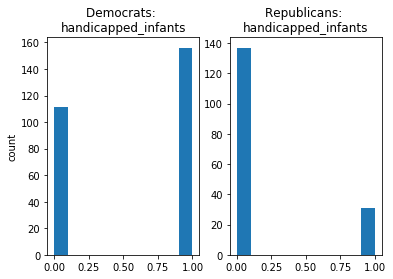

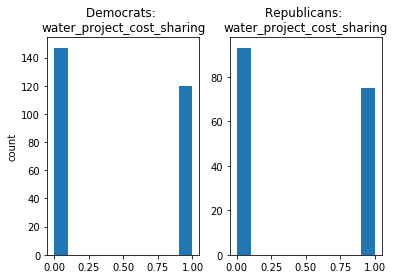

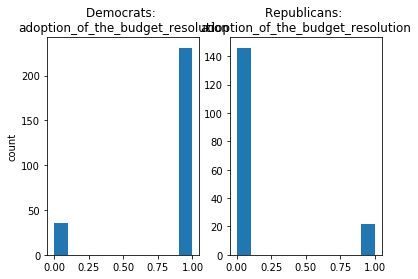

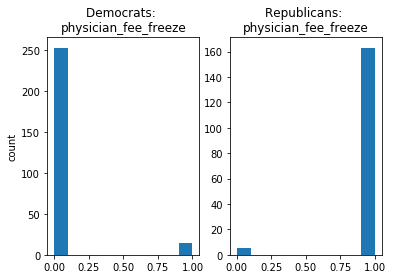

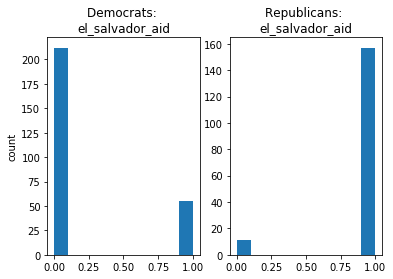

In [4]:
# Let's also convert our dataframe columns to "category" type to take advantage
# categorical utilities like facet-based plotting in seaborn
votes['class'] = votes['class'].astype('object').astype(pandas.api.types.CategoricalDtype(categories=['republican', 'democrat']))

values = ['y', 'n', '?']
for c in votes.columns[1:]:
    votes[c] = votes[c].astype('object').astype(
        pandas.api.types.CategoricalDtype(categories=values))
democrats = votes[votes['class'] == 'democrat']
republicans = votes[votes['class'] == 'republican']
for vote_col in votes.columns[1:6]:
    pyplot.subplot(1, 2, 1)
    pyplot.hist([1 if x == 'y' else 0 for x in democrats[vote_col]])
    pyplot.title('Democrats: \n' + vote_col)
    pyplot.ylabel('count')
    pyplot.subplot(1, 2, 2)
    pyplot.hist([1 if x == 'y' else 0 for x in republicans[vote_col]])
    pyplot.title('Republicans: \n' + vote_col)
    pyplot.show()


When examining these charts, keep in mind that there are more Democrats than Republicans in this data set. What is important is the probability of a Yes vote or No vote for the members of each party. Some votes are quite skewed by party affiliation, such as 'adoption of the budget resolution'. Whereas, some votes have similar probabilities by party, such as 'water project cost sharing'. These probabilities of votes by party are used to train the naive Bayes model.

### Train and Test the Model
Now that we understand a bit about the characteristics of the data, it's time to train and test a naive Bayes model. The python `sklearn.naive_bayes` package provides a library that trains a naive Bayes model and produces a model object that can make predictions on new instances.

In [5]:
label_col = 'class'

# We need to convert our categorical values to numeric feature vectors
feature_vecs = numpy.array([
        votes[c].cat.codes 
        for c in votes.columns 
        if c != label_col]).T
feature_vecs.shape

(435, 16)

In [6]:
# we also need to convert our label (democrat vs republican) to numeric values
labels = votes[label_col].cat.codes
# take a look at the mapping for the first 5 values like so
list(zip(votes[label_col][:5], labels[:5]))

[('republican', 0),
 ('republican', 0),
 ('democrat', 1),
 ('democrat', 1),
 ('democrat', 1)]

In [7]:
import sklearn.naive_bayes

# Define the model
model = sklearn.naive_bayes.MultinomialNB(alpha=1e-7)
# Train the model with our votes dataset
model.fit(feature_vecs, labels)

MultinomialNB(alpha=1e-07, class_prior=None, fit_prior=True)

### Evaluate Model Performance
With the model computed, let's evaluate the performance. We can get a quick overview of the model's effectiveness by printing the first 10 rows of the result. Execute the code in the cell below to print the first 10 rows of the result and examine the result.

In [8]:
predicted_party = model.predict(feature_vecs[:10])
party_probabilities = model.predict_proba(feature_vecs[:10])

results = pandas.DataFrame({
        'party': votes['class'][:10],
        'predicted': pandas.Categorical.from_codes(
            predicted_party, votes['class'][:10].cat.categories),
        'proba(Republican)': party_probabilities[:, 0],
        'proba(Democrat)': party_probabilities[:, 1],
    })
results

,party,predicted,proba(Republican),proba(Democrat)
0,republican,republican,0.999380,0.000620
1,republican,republican,0.998440,0.001560
2,democrat,democrat,0.098967,0.901033
3,democrat,democrat,0.002038,0.997962
4,democrat,democrat,0.084976,0.915024
5,democrat,republican,0.500349,0.499651
6,democrat,republican,0.925406,0.074594
7,republican,republican,0.998216,0.001784
8,republican,republican,0.998800,0.001200
9,democrat,democrat,0.000062,0.999938


As you examine these results notice:
1. There is 1 classification error, with 9 cases correctly classified.
2. In most cases, the probability of the class predicted (score) is much larger than for the other class, including for the cases with classification errors.
3. One case has nearly identical probabilities for the classes.

As a next step, we can compute the confusion matrix and performance metrics for this model.

In [9]:
import sklearn.metrics

def confusion_matrix(labels, predicted_labels, label_classes):
    return pandas.DataFrame(
        sklearn.metrics.confusion_matrix(labels, predicted_labels),
        index=[label_classes], 
        columns=label_classes)    

def performance(results):
    accuracy = sklearn.metrics.accuracy_score(
        results['party'].cat.codes, results['predicted'].cat.codes)
    precision = sklearn.metrics.precision_score(
            results['party'].cat.codes, results['predicted'].cat.codes)
    recall = sklearn.metrics.recall_score(
            results['party'].cat.codes, results['predicted'].cat.codes)

    print('Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (accuracy, precision, recall))
    
    return confusion_matrix(
        results['party'], 
        results['predicted'], 
        results.party.cat.categories)

In [10]:
performance(results)

Accuracy = 0.800, Precision = 1.000, Recall = 0.667


,republican,democrat
republican,4,2
democrat,0,4


The results are reasonably good looking at only the first 10 of 435 congresspeople. 

Execute the code in the cell below to compute and print an evaluation of the model using all the data and compare the results to the first model.

In [11]:
predicted_party = model.predict(feature_vecs)
party_probabilities = model.predict_proba(feature_vecs)

results_all = pandas.DataFrame({
        'party': votes['class'],
        'predicted': pandas.Categorical.from_codes(
            predicted_party, votes['class'].cat.categories),
        'proba(democrat)': party_probabilities[:, 0],
        'proba(republican)': party_probabilities[:, 1],
    })
performance(results_all)

Accuracy = 0.901, Precision = 0.938, Recall = 0.899


,republican,democrat
republican,240,27
democrat,16,152


### Laplace Smoothing
The Laplace smoothing method is an effective way to deal with data sets which do not have sufficient samples to compute probabilities. This method avoids the case where $p(x_j|C_k) = 0$. 

The code in the cell below computes a naive Bayes model using the same congressional vote data, but with a Laplace smoother with a span of 3 data points. Execute this code and examine the results. 

In [12]:
# The `alpha` param controls the Laplace smoothing
model = sklearn.naive_bayes.MultinomialNB(alpha=3)
model.fit(feature_vecs, labels)

MultinomialNB(alpha=3, class_prior=None, fit_prior=True)

In [13]:
predicted_party = model.predict(feature_vecs)
party_probabilities = model.predict_proba(feature_vecs)

results_all = pandas.DataFrame({
        'party': votes['class'],
        'predicted': pandas.Categorical.from_codes(
            predicted_party, votes['class'].cat.categories),
        'proba(democrat)': party_probabilities[:, 0],
        'proba(republican)': party_probabilities[:, 1],
    })
performance(results_all)

Accuracy = 0.901, Precision = 0.938, Recall = 0.899


,republican,democrat
republican,240,27
democrat,16,152


The results are similar to the model computed without Laplace smoothing. This result is expected as all the cases in the data set have sufficient data. 

## Another Example - Census Income

Let's try another binary classification example. The code in the cell below loads some sample US Census data. We want to build and evaluate a naive Bayes model to classify people by high and low income using $50,000 as the cut-off. Execute this code and examine the features in the data set. 

In [14]:
income = pandas.read_csv('https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Adult%20Census%20Income%20Binary%20Classification%20dataset.csv', 
                         sep=', ', engine='python')
income.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Reducing Features
We can see some features which are likely to be collinear. There is also one feature, 'fnlwgt', which is not useful in classifying these people. The code in the cell below removes these columns. Execute this code to create a data set with reduced features.

In [15]:
income = income.drop(['workclass', 'fnlwgt', 'education-num', 'relationship'], axis=1)
income.head()

,age,education,marital-status,occupation,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,Bachelors,Never-married,Adm-clerical,White,Male,2174,0,40,United-States,<=50K
1,50,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,0,0,13,United-States,<=50K
2,38,HS-grad,Divorced,Handlers-cleaners,White,Male,0,0,40,United-States,<=50K
3,53,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,0,0,40,United-States,<=50K
4,28,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,0,0,40,Cuba,<=50K


***
## Your Turn 1
Compute a naive Bayes model to classify `income` using the features in the Income data set. Use `laplace = 3` for smoothing.  Print the model and examine the conditional probabilities for the values of the features to get an idea how the classifer works. 
***

In [16]:
# Replace ??? with the correct parameters

for c in income.columns:
    if income[c].dtype == 'object':
        income[c] = income[c].astype('category')

income_label_col = 'income'
income_labels = income[income_label_col].cat.codes

features = []
for c in income.columns:
    if c != income_label_col:
        if str(income[c].dtype) == 'category':
            features.append(income[c].cat.codes)
        else:
            features.append(income[c])
income_feature_vecs = numpy.array(features).T

# Create the Model
model = sklearn.naive_bayes.MultinomialNB(alpha=3)
model.fit(income_feature_vecs, income_labels)

MultinomialNB(alpha=3, class_prior=None, fit_prior=True)

In [17]:
conditional_probas = pandas.DataFrame(model.feature_log_prob_, columns=income.columns[:-1])
conditional_probas

,age,education,marital-status,occupation,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,-2.217135,-3.507143,-4.799374,-3.966972,-4.532512,-6.313061,-0.81991,-1.849207,-2.162735,-2.220803
1,-4.588644,-5.994926,-7.646522,-6.412823,-7.050232,-8.541001,-0.08292,-3.105495,-4.561377,-4.769229


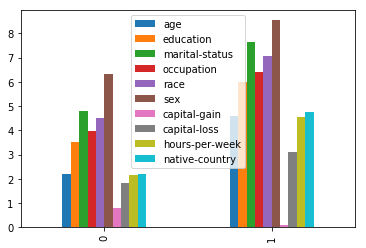

In [18]:
(-conditional_probas).plot(kind='bar')

***
## Your Turn 2
Using the model you computed for predicting peoples' income class, compute predictions (scores). Also compute and print the performance metrics. 
***

In [19]:
# Replace ??? with the correct parameters
predicted_income = model.predict(income_feature_vecs)
income_probabilities = model.predict_proba(income_feature_vecs)

accuracy = sklearn.metrics.accuracy_score(income_labels, predicted_income)
precision = sklearn.metrics.precision_score(income_labels, predicted_income)
recall = sklearn.metrics.recall_score(income_labels, predicted_income)
print('Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (accuracy, precision, recall))
print('Confusion matrix:')
confusion_matrix(income_labels, predicted_income, 
                 income[income_label_col].cat.categories)

Accuracy = 0.779, Precision = 0.620, Recall = 0.214
Confusion matrix:


,<=50K,>50K
<=50K,23693,1027
>50K,6164,1677


## Changing Number of Features

Let's investigate the effect of adding more data samples to the naive Bayes model. The code in the cell below computes and evaluates naive Bayes models using 2, 3, 4, 5 and 6 votes. Execute this code and compare the results to those obtained using the full data set.

In [20]:
label_col = 'class'

# We need to convert our categorical values to numeric feature vectors
feature_vecs = numpy.array([
        votes[c].cat.codes 
        for c in votes.columns 
        if c != label_col]).T
print(feature_vecs.shape)

# we also need to convert our label (democrat vs republican) to numeric values
labels = votes[label_col].cat.codes
# take a look at the mapping for the first 5 values like so
list(zip(votes[label_col][:5], labels[:5]))

(435, 16)


[('republican', 0),
 ('republican', 0),
 ('democrat', 1),
 ('democrat', 1),
 ('democrat', 1)]

In [21]:
for num_features in [2, 3, 4, 5, 6]:
    model = sklearn.naive_bayes.MultinomialNB()
    model.fit(feature_vecs[:, :num_features], labels)

    predicted_votes = model.predict(feature_vecs[:, :num_features])

    print('Number of features = %d' % num_features)
    accuracy = sklearn.metrics.accuracy_score(labels, predicted_votes)
    precision = sklearn.metrics.precision_score(labels, predicted_votes)
    recall = sklearn.metrics.recall_score(labels, predicted_votes)
    print('Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (accuracy, precision, recall))
    print('Confusion matrix:')
    print(confusion_matrix(labels, predicted_votes, votes['class'].cat.categories))
    print('')

Number of features = 2
Accuracy = 0.609, Precision = 0.612, Recall = 0.993
Confusion matrix:
            republican  democrat
republican           0       168
democrat             2       265

Number of features = 3
Accuracy = 0.724, Precision = 0.716, Recall = 0.914
Confusion matrix:
            republican  democrat
republican          71        97
democrat            23       244

Number of features = 4
Accuracy = 0.929, Precision = 0.944, Recall = 0.940
Confusion matrix:
            republican  democrat
republican         153        15
democrat            16       251

Number of features = 5
Accuracy = 0.929, Precision = 0.937, Recall = 0.948
Confusion matrix:
            republican  democrat
republican         151        17
democrat            14       253

Number of features = 6
Accuracy = 0.922, Precision = 0.936, Recall = 0.936
Confusion matrix:
            republican  democrat
republican         151        17
democrat            17       250



You can see from these results, that the model gains accuracy rapidly with just a few features. In fact, 5 or 6 of the 16 features provides equivalent results. 

***
## Your Turn 3
Compute a naive Bayes model, compute and  print the performance statistics for 100, 500, 1000, 2000, 8000, and 32561 rows of the Income data set. How many rows are required until the performance is close to the best possible with the model?
***

In [22]:
# Replace ??? with the Correct Parameters

for num_rows in [100, 500, 1000, 2000, 8000, 32561]:
    model = sklearn.naive_bayes.MultinomialNB()
    model.fit(income_feature_vecs[:num_rows, :], income_labels[:num_rows])

    predicted_income = model.predict(income_feature_vecs[:num_rows, :])
    income_probabilities = model.predict_proba(income_feature_vecs[:num_rows, :])
    
    accuracy = sklearn.metrics.accuracy_score(income_labels[:num_rows], predicted_income)
    precision = sklearn.metrics.precision_score(income_labels[:num_rows], predicted_income)
    recall = sklearn.metrics.recall_score(income_labels[:num_rows], predicted_income)
    print('Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (accuracy, precision, recall))
    print('Confusion matrix:')
    print(confusion_matrix(
            income_labels[:num_rows], predicted_income, income.income.cat.categories), '\n')

Accuracy = 0.750, Precision = 0.500, Recall = 0.120
Confusion matrix:
       <=50K  >50K
<=50K     72     3
>50K      22     3 

Accuracy = 0.782, Precision = 0.553, Recall = 0.186
Confusion matrix:
       <=50K  >50K
<=50K    370    17
>50K      92    21 

Accuracy = 0.777, Precision = 0.556, Recall = 0.194
Confusion matrix:
       <=50K  >50K
<=50K    732    36
>50K     187    45 

Accuracy = 0.770, Precision = 0.610, Recall = 0.216
Confusion matrix:
       <=50K  >50K
<=50K   1432    69
>50K     391   108 

Accuracy = 0.780, Precision = 0.615, Recall = 0.210
Confusion matrix:
       <=50K  >50K
<=50K   5837   251
>50K    1511   401 

Accuracy = 0.779, Precision = 0.620, Recall = 0.214
Confusion matrix:
       <=50K  >50K
<=50K  23693  1027
>50K    6164  1677 



## Summary

In this notebook you have worked through the following:

1. Theory of naive Bayes models
2. Pitfalls of naive Bayes 
3. Good regularization properties 
4. Computationally efficiency 
5. Examples of computing and evaluating naive Bayes models
6. Examine the effects of data set size on the results of naive Bayes models 

<div id="reminder" style="border-radius: 5px; background-color:#f5f5f5;" >
<h3>Reminder</h3>
<p>Use this notebook to answer the quiz questions related to the <b>Your Turn</b> sections.<p>
</div>